In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import h5py
from scipy.io import loadmat
from utils import get_train_data

get_dir = os.getcwd()
os.chdir(get_dir)

2024-12-09 12:09:05.556860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 12:09:05.556892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 12:09:05.558118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 12:09:05.564823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:09:06.219586: W tensorflow/comp

## Pre-Processing for Plots

In [2]:
def get_predictions_and_true_data(mdir, ddir, indices, seq_dir, tlim=1., dm=False):
    
    data = loadmat(ddir)
    seq_ind = pd.read_csv(seq_dir)['sensor_indices'].values
    model = tf.keras.models.load_model(mdir)
    
    xdisc = data['x']
    tdisc = data['tspan']
    X, T = np.meshgrid(xdisc, tdisc)
    
    x_sen = X[0, seq_ind].reshape(1, -1)
    t_sen = T[0, seq_ind].reshape(1, -1)
    tind = np.where(tdisc==tlim)[1].item() + 1
    
    u_pred = []
    u_true = []
    u_init = []
    err = []
    
    for i in indices:
        
        u_sen = data['input'][i, seq_ind].reshape(1, -1)
        xbc = np.repeat(x_sen, len(X[1:tind, :].reshape(-1, 1)), axis=0)
        tbc = np.repeat(t_sen, len(X[1:tind, :].reshape(-1, 1)), axis=0)
        ubc = np.repeat(u_sen, len(X[1:tind, :].reshape(-1, 1)), axis=0)

        if dm:
            u_pred.append(model.predict([X[1:tind, :].reshape(-1, 1), T[1:tind, :].reshape(-1, 1),
                                         ubc], batch_size=4096).reshape(X[1:tind, :].shape))
        else:
            u_pred.append(model.predict([X[1:tind, :].reshape(-1, 1), T[1:tind, :].reshape(-1, 1), 
                                         xbc, tbc, ubc], batch_size=4096).reshape(X[1:tind, :].shape))
        u_true.append(data['output'][i].squeeze()[1:tind, :])
        u_init.append(data['input'][i].reshape(-1))
        err.append(abs(u_true[-1]-u_pred[-1]))

    return X[1:, :], T[1:, :], u_pred, u_true, u_init

In [3]:
def get_plots(x, t, true_val, pred_val, init_val, grid_spec, plot_save, 
              plot_dir, fig_size, shrink=1, dm=False, lxd=[0.5, 0.5], lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, tlim=1., clim=[-0.5, 1.], eclim=[0., 0.08], ln=10, 
              cbar_kwargs=None, value=None, init_value=None):
    
    tind = np.where(t[:, 0].reshape(-1)==tlim)[0].item() + 1
    
    fig, ax = plt.subplots(4, len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    level = np.linspace(clim[0], clim[1], num=ln)
    err_level = np.linspace(eclim[0], eclim[1], num=7)
    
    
    for j in range(len(true_val)):
        
        # level = np.linspace(true_val[j].min(), true_val[j].max(), num=7)
        ax[0][j].plot(x[0, :], init_val[j], color='b', linewidth=1.)
        pre = ax[1][j].contourf(x[:tind, :], t[:tind, :], pred_val[j][:tind, :], level, cmap='rainbow')
        tru = ax[2][j].contourf(x[:tind, :], t[:tind, :], true_val[j][:tind, :], level, cmap='rainbow')
        err = abs(pred_val[j] - true_val[j])/(1 + abs(true_val[j]))
        if dm:
            err = ax[3][j].contourf(x[:tind, :], t[:tind, :], err[:tind, :], err_level, cmap='Blues', extend='both')
            err.cmap.set_under('orange')
            err.cmap.set_over('orange')
        else:
            err = ax[3][j].contourf(x[:tind, :], t[:tind, :], err[:tind, :],err_level, cmap='Blues')

        for row in ax[1:]:
            row[j].set_aspect(value, adjustable='box')    
        for row in ax[0:1]:
            row[j].set_aspect(init_value, adjustable='box')
        
    pcbar = fig.colorbar(pre, ax=ax[1, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        
    tcbar = fig.colorbar(tru, ax=ax[2, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        
    ecbar = fig.colorbar(err, ax=ax[3, :], **cbar_kwargs)
    ecbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

    ax[0][0].set_ylabel('Initial \n Conditions \n u(0, x)', fontsize=10, fontweight='bold')
    if dm:
        ax[1][0].set_ylabel('PI-DeepONets \n Solutions \n t', fontsize=10, fontweight='bold') 
    else:
        ax[1][0].set_ylabel('PINTO \n Solutions \n t', fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel('Numerical \n Solutions \n t', fontsize=10, fontweight='bold')
    ax[3][0].set_ylabel('Relative Error \n t', fontsize=10, fontweight='bold') 
    ax[3][0].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][1].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][2].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][3].set_xlabel('X', fontsize=10, fontweight='bold')
    
    fig.text(lx, 0.9, 'Seen ICs', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, 0.9, 'Unseen ICs', ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

In [4]:
def get_plots_slices(x, t, true_val, pred_val, grid_spec, plot_save, tint, 
              plot_dir, fig_size, shrink=1, lxd=[0.5, 0.5], lyd=[0.1, 0.9],
              lx=0.25, rx=0.75, offset=(0, -10), dm=False, 
              lgd=['PINTO', 'Numerical', 'PI-DeepONets'], 
              pid_pred=None, ncols=2):
    
    tspan = t[:, 0].reshape(-1)
    tlist = [np.where(tspan==tint[0])[0].item(), np.where(tspan==tint[1])[0].item(), np.where(tspan==tint[2])[0].item()]

    
    fig, ax = plt.subplots(3, len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    for j in range(len(true_val)):
        for k, i in enumerate(tlist):
            if (j==2 or j==3) and not dm:
                ind = np.argmax(pred_val[j][i, :].squeeze())
                px = x[0, ind]
                py = pred_val[j][i, ind]
            
                # Add marker point
                ax[k][j].plot(px, py, 'ro')  # red dot at the point

                # Add text marker (letter 'A' slightly above the point)
                ax[k][j].annotate('A', 
                    (px, py),
                    xytext=offset,        # 10 points vertical offset
                    textcoords='offset points',
                    ha='center',           # horizontal alignment
                    va='bottom',           # vertical alignment
                    fontsize=8,
                    fontweight='bold')
            
            ax[k][j].plot(x[0, :], pred_val[j][i, :], 'b', linewidth=1.5, label=lgd[0])
            ax[k][j].plot(x[0, :], true_val[j][i, :], '--', color='green', linewidth=1.5, label=lgd[1])
            if pid_pred is not None:
                ax[k][j].plot(x[0, :], pid_pred[j][i, :], '-.', color='red', linewidth=1.5, label=lgd[2])
            
            ax[k][j].grid(True, which='major', linestyle='-', alpha=0.5)
            ax[k][j].grid(True, which='minor', linestyle='--', alpha=0.2)
            ax[k][j].minorticks_on()
            
        

    ax[0][0].legend(fancybox=False, frameon=False, ncols=ncols, fontsize=10, title_fontproperties={'weight':'bold'}, loc='lower center')
    ax[0][0].set_ylabel(f'u(t={tint[0]}, x)', fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(f'u(t={tint[1]}, x)', fontsize=10, fontweight='bold') 
    ax[2][0].set_ylabel(f'u(t={tint[2]}, x)', fontsize=10, fontweight='bold')
    ax[2][0].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][1].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][2].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][3].set_xlabel('X', fontsize=10, fontweight='bold')
    
    fig.text(lx, 0.9, 'Seen ICs', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, 0.9, 'Unseen ICs', ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure-5: Burgers equation plots 

In [5]:
mdir = '../Trained_models/Burgers_PINTO/Burgers_model.keras'
ddir = '/mnt/PDE_Bench_data/burgers_1d_t10.mat'
seq_dir = '../Trained_models/Burgers_PINTO/seq.csv'
indices = [49, 33, 181, 91]
x, t, tno_pred_val, tno_true_val, tno_init_val = get_predictions_and_true_data(mdir, ddir, indices, seq_dir, tlim=10.)

2024-12-09 12:09:16.504140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47184 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:17:00.0, compute capability: 7.5


50/50 [==============================] - 1s 10ms/step


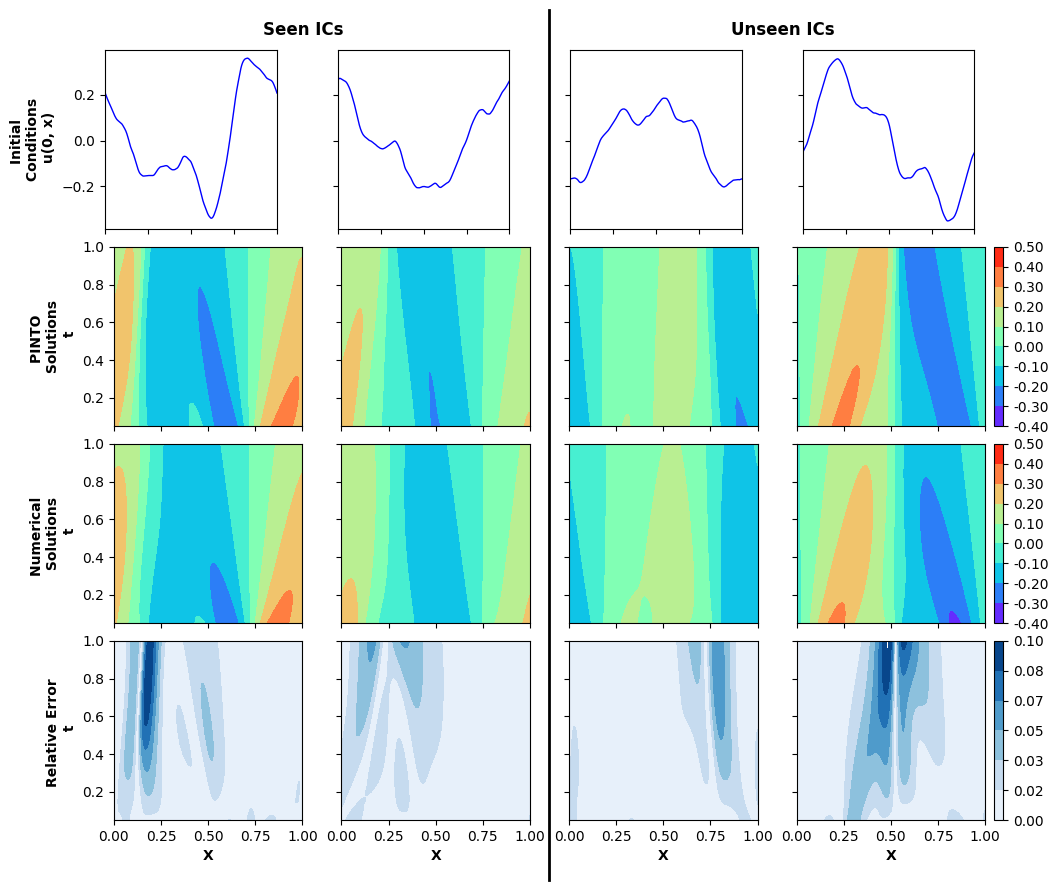

In [6]:
pdir = 'Figure_5'

cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0., 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1, 1]}
get_plots(x,  t, 
          tno_true_val, tno_pred_val, tno_init_val, plot_save=True,
          grid_spec=grid_spec, plot_dir=pdir, fig_size=(12,10), shrink=1, lxd=[0.52, 0.52], lyd=[0.05, 0.92], 
          lx=0.315, rx=0.715, tlim=1., clim=[-0.4, .5], eclim=[0., 0.1], ln=10, 
	  cbar_kwargs=cbar_kwargs, value=1./1., init_value=1./0.75)

In [7]:
# pdir = 'PINTO_Burgers_analysis_plots'

# grid_spec = {'wspace': 0.05, 'hspace': 0.05, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
# get_plots_slices(x,  t, tno_true_val, tno_pred_val, plot_save=False, tint=[0.05, 0.7, 1.5],
#                 grid_spec=grid_spec, plot_dir=pdir, fig_size=(15,6), shrink=1, 
#                 lxd=[0.512, 0.512], lyd=[0.05, 0.92], 
#                 lx=0.312, rx=0.712, 
#                 offset=(0, -15), lgd=['PINTO \n Prediction', 'Numerical \n Solution'])

## Plots for PI-DeepONets

In [10]:
mdir = '../Trained_models/Burger_DeepONet/Burgers_Deeponet_model.keras'
seq_dir = '../Trained_models/Burger_DeepONet/seq.csv'
x, t, pid_pred_val, pid_true_val, init_val = get_predictions_and_true_data(mdir, ddir, indices, seq_dir, dm=True, tlim=10.)

50/50 [==============================] - 0s 3ms/step


In [11]:
# pdir = 'PI_DeepONets_Burgers_training_testing_plots'
# pt = ['Initial Value', 'TNO Solutions', 'Numerical Solutions']

# grid_spec = {'wspace': 0.1, 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1, 1]}
# get_plots(x,  t, 
#           pid_true_val, pid_pred_val, init_val, plot_save=True, dm=True,
#           grid_spec=grid_spec, plot_dir=pdir, fig_size=(10,8), shrink=1, lxd=[0.512, 0.512], lyd=[0.1, 0.92], 
#           lx=0.315, rx=0.715, tlim=1., clim=[-1.5, 1.], eclim=[0., 0.1])

## Figure-6: Burgers equation plots 

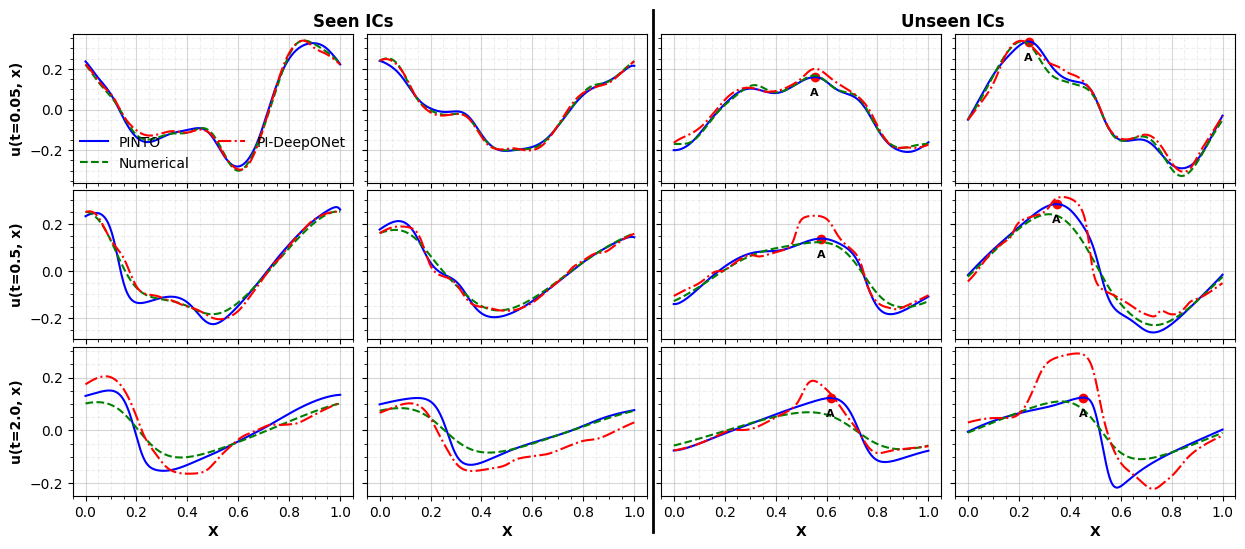

In [12]:
pdir = 'Combined_Burgers_analysis_plots'
grid_spec = {'wspace': 0.05, 'hspace': 0.05, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}

get_plots_slices(x,  t, tno_true_val, tno_pred_val, plot_save=True, tint=[0.05, 0.5, 2.],
                grid_spec=grid_spec, plot_dir=pdir, fig_size=(15,6), shrink=1, 
                lxd=[0.512, 0.512], lyd=[0.05, 0.92], 
                lx=0.312, rx=0.712, 
                offset=(0, -15), lgd=['PINTO', 'Numerical', 'PI-DeepONet'], 
		pid_pred=pid_pred_val, ncols=2)

## Table 1: Performance metrics Burgers and PI-DeepONet comparison

In [13]:
def get_metrics(ddir, idx_seq, mdir, train_indices, test_indices, dm=False):

	(txtrain, tttrain, tutrain, txbc_train, ttbc_train, tubc_train,
  txtest, tttest, tutest, txbc_test, ttbc_test, tubc_test) = get_train_data(data_dir=ddir, idx_seq=idx_seq, train_indices=train_indices, 
                                                              test_indices=test_indices)
	train_metric_mean = []
	test_metric_mean = []
	train_metric_std = []
	test_metric_std = []
	for i, j in enumerate(mdir):
		model = tf.keras.models.load_model(mdir[i])
		if dm:
			train_pred = model.predict([txtrain, tttrain, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, tubc_test], batch_size=4096)
		else:
			train_pred = model.predict([txtrain, tttrain, txbc_train, ttbc_train, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, txbc_test, ttbc_test, tubc_test], batch_size=4096)

		train_metric_mean.append(np.mean(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_mean.append(np.mean(abs((tutest - test_pred)/(1 + abs(tutest)))))
		train_metric_std.append(np.std(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_std.append(np.std(abs((tutest - test_pred)/(1 + abs(tutest)))))

	return pd.DataFrame({'train_metric_mean': train_metric_mean, 'test_metric_mean': test_metric_mean, 
                      'train_metric_std': train_metric_std, 'test_metric_std': test_metric_std})

In [14]:
## PINTO metrics

mdir = ['../Trained_models/Burgers_PINTO/Burgers_model.keras']
idx_seq = pd.read_csv('../Trained_models/Burgers_PINTO/seq.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)
metrics = get_metrics(ddir, idx_seq, mdir, train_indices, test_indices)

metrics

1000/1000 [==============================] - 11s 11ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
0,0.048095,0.052477,0.044265,0.045097


In [17]:
## PI-DeepONet metrics

mdir = ['../Trained_models/Burger_DeepONet/Burgers_Deeponet_model.keras']
idx_seq = pd.read_csv('../Trained_models/Burger_DeepONet/seq.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(ddir, idx_seq, mdir, train_indices, test_indices, dm=True)
metrics

1000/1000 [==============================] - 4s 4ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
0,0.128059,0.118543,0.150383,0.107805


## Table: A.2: Hyperparameter tuning for Burgers 

In [22]:
def get_metrics(elist, ddir, idx_seq, mdir, train_indices, test_indices, index):

	(txtrain, tttrain, tutrain, txbc_train, ttbc_train, tubc_train,
  txtest, tttest, tutest, txbc_test, ttbc_test, tubc_test) = get_train_data(data_dir=ddir, idx_seq=idx_seq, train_indices=train_indices, 
                                                              test_indices=test_indices)
	train_metric_mean = []
	test_metric_mean = []
	train_metric_std = []
	test_metric_std = []
	for i, j in enumerate(elist):
		model = tf.keras.models.load_model(mdir[i])
		
		train_pred = model.predict([txtrain, tttrain, txbc_train, ttbc_train, tubc_train], batch_size=4096)
		test_pred = model.predict([txtest, tttest, txbc_test, ttbc_test, tubc_test], batch_size=4096)

		train_metric_mean.append(np.mean(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_mean.append(np.mean(abs((tutest - test_pred)/(1 + abs(tutest)))))
		train_metric_std.append(np.std(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_std.append(np.std(abs((tutest - test_pred)/(1 + abs(tutest)))))

	return pd.DataFrame({'train_metric_mean': train_metric_mean, 'test_metric_mean': test_metric_mean, 
                      'train_metric_std': train_metric_std, 'test_metric_std': test_metric_std}, index=index)

In [21]:
elist = [1, 2]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir + str(i) + '/experiment_' + str(i) + '_model' for i in elist ]
idx_seq = pd.read_csv(base_dir + str(1) + '/seq.csv')['sensor_indices'].values
ddir = '/mnt/PDE_Bench_data/burgers_1d_t10.mat'
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(elist, ddir, idx_seq, mdir, train_indices, test_indices, index=['experiment_1', 'experiment_2'])

metrics

1000/1000 [==============================] - 9s 9ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
0,0.055938,0.060682,0.047659,0.052079
1,0.056705,0.055817,0.042891,0.041304


In [24]:
elist = [3]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir + str(i) + '/experiment_' + str(i) + '_model.keras' for i in elist ]
idx_seq = pd.read_csv(base_dir + str(1) + '/seq.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)
metrics = get_metrics(elist, ddir, idx_seq, mdir, train_indices, test_indices, index=['experiment_3'])

metrics

1000/1000 [==============================] - 11s 10ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
experiment_3,0.048095,0.052477,0.044265,0.045097
